Here, we download the weights of all models trained on MPRA data from the Agarwal et al. paper, although later we can retrain the model in a simpler scenario and avoided downloading all 90 models. 

This models, however, can be used to access not only the predicted expression, but the model confidence in the prediction. 

In [6]:
!curl https://zenodo.org/records/10558183/files/final_dump.zip -O 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3342M  100 3342M    0     0  15.0M      0  0:03:42  0:03:42 --:--:-- 14.7M
curl: (6) Could not resolve host: legnet_weights.zip


In [8]:

!unzip final_dump.zip

Archive:  legnet_weights.zip
   creating: final_dump/
   creating: final_dump/scores/
   creating: final_dump/scores/final/
   creating: final_dump/scores/final/HepG2/
   creating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_2.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_10.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_6.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_3.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_7.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_5.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/testfold_4.tsv  
  inflating: final_dump/scores/final/HepG2/md_shift_reverse_noavg_noch_testaug/

In [1]:
!mv final_dump legnet_weights

mv: cannot stat 'final_dump': No such file or directory


## Loading trained model and it's weights

In [1]:
LEGNET_WEIGHTS_DIR="legnet_weights"
DEVICE = "cpu"

In [2]:
cell_line = "HepG2"

In [3]:
from legnet.config import TrainingConfig
config_path= f"{LEGNET_WEIGHTS_DIR}/models/{cell_line}/md_shift_reverse_noavg_noch/config.json"
val_fold=9
test_fold=6
model_path = f"{LEGNET_WEIGHTS_DIR}/models/{cell_line}/md_shift_reverse_noavg_noch/best_model_test{test_fold}_val{val_fold}.ckpt"

In [4]:
import torch
def load_model(config_path: str, weights_path: str):
    config = TrainingConfig.from_json(config_path)
    model = config.get_model()

    # LegNet was trained using pytorch-lightning framework. However, it is relatively easy to move code to raw PyTorch 
    weights = torch.load(weights_path, map_location='cpu', weights_only=False)['state_dict']
    weights = {key.replace('model.', ''): value for key, value in weights.items()}
    model.load_state_dict(weights);
    model.eval(); 
    return model, config

In [5]:
model, config = load_model(config_path, model_path)

## Predicting for one sequence (200 bp)

Since the model was trained on sequences (200 bp) with flanks (15 bp + 15 bp) attached, we should do the same for the sequences we want predictions for

In [6]:
from legnet.transforms import Seq2Tensor, AddFlanks


from legnet.agarwal_meta import SEQUENCE_SIZE, LEFT_MPRA_FLANK, RIGHT_MPRA_FLANK

In [7]:
import torch.nn as nn 
SingleSeqTransform = nn.Sequential(AddFlanks(up=LEFT_MPRA_FLANK,
                                               down=RIGHT_MPRA_FLANK),
                                   Seq2Tensor())

In [8]:
def predict_singleseq(model, seq: str, transform=SingleSeqTransform, device=DEVICE):
    model.to(device);
    batch = transform(seq).unsqueeze(0).to(device)
    with torch.inference_mode():
        pred = model(batch)
    model.to('cpu')
    return pred.item()

In [9]:
sequence = 'CCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCCTCAGCCGGCCCGCCCGCCCGGGTCTGACCTGAGGAGAACTGTGCTCCGCCTTCAGAGTACCACCGAAATCTGTGCAGAGGACAACGCAGCTCCGCCCTCGCGGTGCTCTCCGGGTCTGTGCTGAGGAGAACG'

In [10]:

predict_singleseq(model, sequence)

-0.6442775726318359

## Predicting for one sequence (<200 bp)

In general, I doubt that MPRA models can generalize to sequences significantly shorter than those they were trained on as they learned position-specific effects.  

However, we still can do the prediction

In case of MPRALegNet as it uses Global Average Pooling, there is no **technical** need to pad sequence until it too short to be propagated through intermediate pooling layers.  

In [11]:
config.get_min_seq_size() # this calculation doesn't account for flanks we could add

16

In [12]:
sequence = 'A' * 16 
predict_singleseq(model, sequence)

-0.44441431760787964

However, as we observed during some experiments with TF binding data, in some cases passing sequence of the same size even using padding by N's or random sequences, increases generalizability. Anyway, sometimes it doesn't affect anything

In [13]:
from legnet.transforms import PadNs

In [14]:
SingleSeqTransformPad = nn.Sequential(AddFlanks(up=LEFT_MPRA_FLANK,
                                               down=RIGHT_MPRA_FLANK),
                                      PadNs(size=200),
                                      Seq2Tensor())

In [15]:
predict_singleseq(model, sequence, transform=SingleSeqTransformPad)

0.3544312119483948

## Predicting for one sequence (>200 bp)

If sequence length doesn't differ significantly from 200bp, it is again still possible to perform prediction without additional operations

In [16]:
sequence = 'A' * 210

predict_singleseq(model, sequence)

0.2012150138616562

If sequence is a way larger than 200bp, it's better to do prediction using sliding window approach.

In [17]:
from Bio import SeqIO
seqrec = SeqIO.read("sequence.fasta", format='fasta')
sequence = str(seqrec.seq)
ch, se = seqrec.name.split(":")
start, end = map(int, se.split('-'))
ch, start, end

('chrX', 48777634, 48790694)

In [18]:
from legnet.dataset import SubSequenceDataset
from torch.utils.data import DataLoader

In [19]:
import tqdm
import numpy as np 

def predict_bigseq(model, 
                   seq: str, 
                   step: int = 50,
                   transform=SingleSeqTransformPad, 
                   window_size: int = 200, 
                   device=DEVICE,
                   monitor_progress: bool = True):
    ds = SubSequenceDataset(sequence=sequence, 
                        window_size=window_size, 
                        step=step, 
                        transform=transform)
    dl = DataLoader(dataset=ds, batch_size=1, shuffle=False)
    offsets = []
    preds = []

    model.to(device)
    with torch.inference_mode():
        with tqdm.tqdm(total=len(ds), disable = not monitor_progress) as pbar:
            for X, of in dl:
                X = X.to(device)
                pr = model(X).cpu().numpy()
                preds.append(pr)
                offsets.append(of.numpy())
                pbar.update(X.shape[0])

    preds = np.concatenate(preds)
    offsets = np.concatenate(offsets)
    model.to('cpu')
    return preds, offsets 

In [20]:
preds, off = predict_bigseq(model, seq=sequence, step=50, transform=SingleSeqTransform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 137.34it/s]


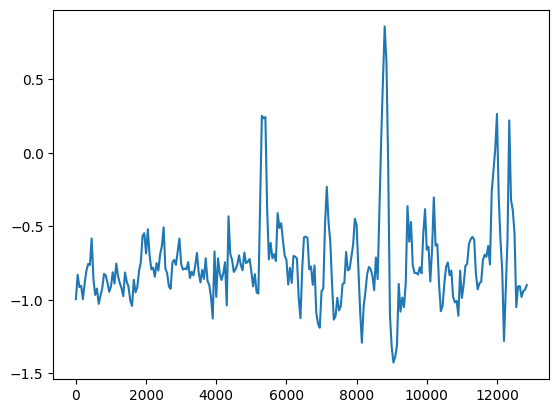

In [21]:
import matplotlib.pyplot as plt 
plt.plot(off, preds)
plt.show();

**TODO**: then adding to chorus, this predictions will be converted to bedgrapgh using existing utilities 

## Predicting for one sequence (with confidence through ensemble)

For many model types (both MPRA-based and not) we have a number of models trained using different folds, seeds, etc.

In this case, we might want to get better predictions using ensemble average. Also, it is possible to access model confidence.

In [22]:
from itertools import permutations

model_paths = {f"model_{test_fold}_{val_fold}" : f"{LEGNET_WEIGHTS_DIR}/models/{cell_line}/md_shift_reverse_noavg_noch/best_model_test{test_fold}_val{val_fold}.ckpt" 
                for test_fold, val_fold in permutations(range(1, 11), 2) if val_fold == 1} # take only 9 out of 90 models

In [23]:
model_paths

{'model_2_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test2_val1.ckpt',
 'model_3_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test3_val1.ckpt',
 'model_4_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test4_val1.ckpt',
 'model_5_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test5_val1.ckpt',
 'model_6_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test6_val1.ckpt',
 'model_7_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test7_val1.ckpt',
 'model_8_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test8_val1.ckpt',
 'model_9_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test9_val1.ckpt',
 'model_10_1': 'legnet_weights/models/HepG2/md_shift_reverse_noavg_noch/best_model_test10_val1.ckpt'}

In [24]:
import pandas as pd

def predict_ensemble(config_path: str,
                     model_paths: dict[str, str],
                     seq: str, 
                     step: int = 50,
                     transform=SingleSeqTransformPad, 
                     window_size: int = 200, 
                     device=DEVICE,
                     monitor_progress: bool = True):
    ensemble_preds = {}
    for name, mp in tqdm.tqdm(model_paths.items(), disable=not monitor_progress):
        model, _ = load_model(config_path=config_path, weights_path=mp)
        preds, offs = predict_bigseq(model, seq=sequence, step=step, transform=transform, window_size=window_size, device=device, monitor_progress=False)
        ensemble_preds[name] = preds
    ensemble_preds['offset'] = offs

    
    return pd.DataFrame(ensemble_preds)

In [25]:
preds = predict_ensemble(config_path=config_path,
                              model_paths=model_paths, 
                              seq=sequence, 
                              step=50, 
                              transform=SingleSeqTransform)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.96s/it]


In [26]:
preds

,model_2_1,model_3_1,model_4_1,model_5_1,model_6_1,model_7_1,model_8_1,model_9_1,model_10_1,offset
0,-0.935884,-0.714414,-1.067297,-0.981644,-1.138256,-1.108349,-1.108798,-1.167752,-0.896741,0
1,-0.748255,-0.544055,-0.811571,-0.688158,-0.999472,-0.757055,-0.873338,-0.730851,-0.740480,50
2,-0.801911,-0.682842,-0.800910,-0.861361,-0.947408,-0.889952,-0.887624,-0.872693,-0.878857,100
3,-0.895687,-0.768124,-0.805489,-0.788829,-1.038516,-0.960561,-0.880746,-0.912001,-0.891269,150
4,-0.828390,-0.708733,-0.930222,-0.870231,-1.041875,-1.057306,-0.881545,-0.920502,-0.911254,200
...,...,...,...,...,...,...,...,...,...,...
253,-0.782261,-0.825962,-1.040849,-0.946537,-1.026208,-0.881579,-0.893345,-0.974999,-0.866371,12650
254,-0.794585,-0.914332,-0.928968,-0.938060,-0.963860,-0.910674,-0.854167,-0.926551,-0.901570,12700
255,-0.820289,-0.749581,-0.853422,-0.846051,-0.959389,-0.896061,-0.845005,-0.966264,-0.851932,12750
256,-0.835958,-0.676307,-0.691319,-0.619952,-0.927901,-0.862165,-0.831009,-0.811564,-0.838990,12800


In [27]:
preds_long = pd.melt(preds, id_vars=['offset'], var_name='model_id', value_name='activity')

In [28]:
preds_long

,offset,model_id,activity
0,0,model_2_1,-0.935884
1,50,model_2_1,-0.748255
2,100,model_2_1,-0.801911
3,150,model_2_1,-0.895687
4,200,model_2_1,-0.828390
...,...,...,...
2317,12650,model_10_1,-0.866371
2318,12700,model_10_1,-0.901570
2319,12750,model_10_1,-0.851932
2320,12800,model_10_1,-0.838990


<Axes: xlabel='offset', ylabel='activity'>

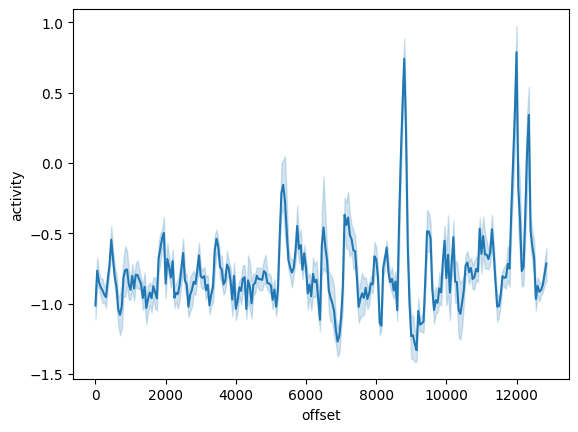

In [29]:
import seaborn as sns
sns.lineplot(data=preds_long, x='offset', y="activity", errorbar=('ci', 99))

## Predicting for one sequence (with confidence through test-time augmentation)

Even in the case of having only one model, it is possible to test-time augment its predictions. E.g, it has been shown that Enformer's prediction is not stable under 2–3 bp shifts of the input sequence. 
Also, while Enformer was trained in strand-agnostic manner, it's predictions for different strands can be drastically different. 


It seems that the most convinient method to do that (at least in PyTorch) is by using transforms

In [30]:
def predict_bigseq_testaug(model, 
                   seq: str, 
                   testaug_transforms: dict[str, nn.Module],
                   step: int = 50,
                   window_size: int = 200, 
                   device=DEVICE,
                   monitor_progress: bool = True):
    test_aug_preds = {}
    for tr_name, tr in tqdm.tqdm(testaug_transforms.items(), disable=not monitor_progress):
        preds, offs = predict_bigseq(model, 
                                     seq=seq, 
                                     step=step,
                                     transform=tr, 
                                     window_size=window_size, 
                                     device=device,
                                     monitor_progress=False)
        test_aug_preds[tr_name] = preds
    test_aug_preds['offset'] = offs
    test_aug_preds = pd.DataFrame(test_aug_preds)
        
    return test_aug_preds

### Reverse-complement

In [31]:
from legnet.transforms import ReverseComplement

In [32]:
transforms = {'forw': nn.Sequential(AddFlanks(up=LEFT_MPRA_FLANK,
                                               down=RIGHT_MPRA_FLANK),
                                      PadNs(size=200),
                                      Seq2Tensor()), # no change 
              'rev': nn.Sequential(ReverseComplement(),
                                   AddFlanks(up=LEFT_MPRA_FLANK,
                                             down=RIGHT_MPRA_FLANK),
                                   PadNs(size=200),
                                   Seq2Tensor())}

In [33]:
preds = predict_bigseq_testaug(model, 
                               seq=sequence, 
                               testaug_transforms=transforms,
                               step=50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


In [34]:
preds

,forw,rev,offset
0,-0.995426,-0.947486,0
1,-0.829827,-0.887152,50
2,-0.913114,-0.848000,100
3,-0.905681,-0.869196,150
4,-0.995767,-0.835569,200
...,...,...,...
253,-0.906553,-0.956573,12650
254,-0.980546,-1.051354,12700
255,-0.940943,-1.002188,12750
256,-0.930806,-0.991675,12800


### Shift-based augmentation

In case of Enformer-like models, such augmentation can be performed just by making predictions not only for __chr:start:end__ position, but for __chr:start+shift:end+shift__, shift $\in$ [-3, 3] and averaging resulting tracks.



For models trained on MPRA data, the situation is more complicated because we need to include the plasmid surroundings of the sequence. In the case of the Agarwal et al. data, for example, additional flanks were added to the first two

In [42]:
from legnet.agarwal_meta import LEFT_SECOND_MPRA_FLANK, RIGHT_SECOND_MPRA_FLANK

In [43]:
transforms = {}

for shift in range(-5, 0):
    transforms[f'sh_{shift}'] = nn.Sequential(AddFlanks(up=LEFT_SECOND_MPRA_FLANK[shift:] + LEFT_MPRA_FLANK,
                                               down=RIGHT_MPRA_FLANK[:shift]),
                                      PadNs(size=200),
                                      Seq2Tensor())
transforms[f'sh_0'] =  nn.Sequential(AddFlanks(up=LEFT_MPRA_FLANK,
                                               down=RIGHT_MPRA_FLANK),
                                      PadNs(size=200),
                                      Seq2Tensor())

for shift in range(1, 6):
    transforms[f'sh_{shift}'] = nn.Sequential(AddFlanks(up=LEFT_MPRA_FLANK[shift:],
                                               down=RIGHT_MPRA_FLANK + RIGHT_SECOND_MPRA_FLANK[:shift]),
                                      PadNs(size=200),
                                      Seq2Tensor())

In [44]:
preds = predict_bigseq_testaug(model, 
                               seq=sequence, 
                               testaug_transforms=transforms,
                               step=50)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.64s/it]


In [45]:
preds

,sh_-5,sh_-4,sh_-3,sh_-2,sh_-1,sh_0,sh_1,sh_2,sh_3,sh_4,sh_5,offset
0,-1.065913,-1.035169,-0.991491,-1.062824,-1.056525,-0.995426,-0.976978,-1.034807,-0.989252,-0.964985,-0.939186,0
1,-0.711634,-0.769002,-0.701949,-0.808158,-0.746477,-0.829827,-0.758668,-0.814151,-0.745025,-0.796776,-0.752255,50
2,-0.927957,-0.966832,-0.887712,-0.951747,-0.903118,-0.913114,-0.867570,-0.880326,-0.849084,-0.895269,-0.847363,100
3,-0.930629,-0.976830,-0.939243,-0.972578,-0.894161,-0.905681,-0.906522,-0.941971,-0.845814,-0.908182,-0.884709,150
4,-0.977176,-1.034337,-0.911630,-0.995112,-0.947447,-0.995767,-0.881252,-0.949578,-0.896181,-0.964262,-0.871575,200
...,...,...,...,...,...,...,...,...,...,...,...,...
253,-0.934443,-0.923090,-0.939881,-0.929818,-0.927996,-0.906553,-0.950612,-0.918143,-0.893746,-0.891028,-0.926304,12650
254,-1.053578,-0.994467,-1.021644,-0.950862,-1.036840,-0.980546,-1.001977,-0.937636,-1.023294,-0.968559,-1.005241,12700
255,-1.011989,-0.972884,-1.037458,-0.973697,-1.007854,-0.940943,-1.013408,-0.929088,-1.003372,-0.949962,-1.032807,12750
256,-1.062893,-0.969880,-1.032156,-0.969730,-1.047393,-0.930806,-0.987212,-0.922630,-1.005762,-0.927957,-0.984369,12800


In [46]:
preds_long = pd.melt(preds, id_vars=['offset'], var_name='shift', value_name='activity')

<Axes: xlabel='offset', ylabel='activity'>

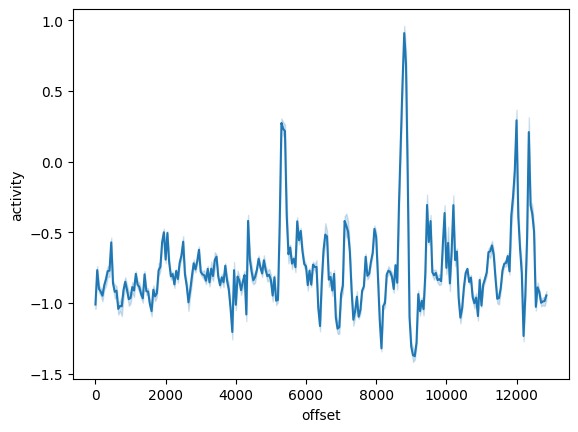

In [47]:
import seaborn as sns
sns.lineplot(data=preds_long, x='offset', y="activity", errorbar=('ci', 99))